# Author: Albarello Michael Anthony

# Blind source separation
The purpose of the project is to separate an image obtained as a sum of a two images into its components. 

The two images `img1` and `img2` summed together come from different dataset: ***mnist*** and ***fashion_mnist***, respectively.

<u>No preprocessing is allowed</u>. The network takes in input the sum img1+img2 and returns the predicted components hat_img1 and hat_img2. 

The metric used to evaluate the project is the ***mean squared error*** between predicted and ground truth images.


In [ ]:
import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras.datasets import mnist, fashion_mnist

import numpy as np
from matplotlib import pyplot as plt

Here we load the two datasets, mnist and fashion mnist (both in grayscale).

For simplicity, the samples are padded to dimension (32,32).

In [ ]:
#import and load mnist dataset
(mnist_x_train, mnist_y_train), (mnist_x_test, mnist_y_test) = mnist.load_data()

#import and load mnist dataset
(fashion_mnist_x_train, fashion_mnist_y_train), (fashion_mnist_x_test, fashion_mnist_y_test) = fashion_mnist.load_data()

#normnalize in and pad
mnist_x_train = np.pad(mnist_x_train,((0,0),(2,2),(2,2)))/255.   #adds padding around matrix to make the resolution 32x32
mnist_x_test = np.pad(mnist_x_test,((0,0),(2,2),(2,2)))/255.

fashion_mnist_x_train = np.pad(fashion_mnist_x_train,((0,0),(2,2),(2,2)))/255.
fashion_mnist_x_test = np.pad(fashion_mnist_x_test,((0,0),(2,2),(2,2)))/255.


#Check data sizes:
print(f"\n\nMnist sample size: {np.shape(mnist_x_train)}\n")
print(f"Fashion-Mnist sample size: {np.shape(fashion_mnist_x_train)}\n")
print(f"Padded sample size: {np.shape(mnist_x_train)}")



Mnist sample size: (60000, 32, 32)

Fashion-Mnist sample size: (60000, 32, 32)

Padded sample size: (60000, 32, 32)


Here is a simple datagenerator.

In [ ]:
def datagenerator(x1,x2,batchsize):
    n1 = x1.shape[0]
    n2 = x2.shape[0]
    while True:
        num1 = np.random.randint(0, n1, batchsize)
        num2 = np.random.randint(0, n2, batchsize)

        x_data = (x1[num1] + x2[num2]) / 2.0
        y_data = np.concatenate((x1[num1], x2[num2]), axis=2)
        
        #print(y_data)
        
        yield x_data, y_data 

Here we define two generators, one for training and one for testing. You may possibly add an addition generator for validation, further splitting the dataset.

In [ ]:
train_generator = datagenerator(mnist_x_train,fashion_mnist_x_train, 1)
test_generator = datagenerator(mnist_x_test,fashion_mnist_x_test, 1)

Let us look at some input-output pairs

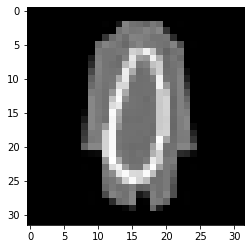

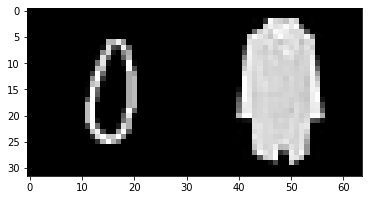

In [ ]:
x, y = next(train_generator)
plt.imshow(x[0],cmap='gray', interpolation='nearest')
plt.show()
plt.imshow(y[0], cmap='gray', interpolation='nearest')
plt.show()

# **1. Model Architecture**

The model architecture I have choosen is the ***UNet***, a Convolutional Neural Network that was originally developed for biomedical image segmentation, but successively used in semantic segmentation. UNet networks have the following <a href= "https://miro.medium.com/max/828/1*f7YOaE4TWubwaFF7Z1fzNw.webp">structure</a>

Conceptually with UNets, the samples are repeatedly downsized until the wanted dimensions are achieved and later repeatedly upsized to the original dimensions. For each sample size, the same arbitrary number of convolutions are performed and the number of filters per convolution layer gets doubled when downsampling or divided by two when upsampling.  

Usually everytime we downsample images there will be information loss; with UNets this problem is solved by adding skip connections to the upsampling part of the network. Also, these skip connections act as training stabilizers to overcome overfitting. 

## **2. Generate the model**

The following function is capable of creating a UNet based model.


In [ ]:
#GENERATE UNET MODEL

from tensorflow.keras.layers import Input, Conv2D, concatenate, MaxPooling2D, Reshape, BatchNormalization, UpSampling2D
from tensorflow.keras.models import Model


def generate_unet(input_shape, kernel_num, floor_num, convs_num, batch_norm):

  unet_input = Input(shape = input_shape, name = 'InputLayer')

  #DOWNSIZING:
  skip_layers = []
  x = unet_input

  for i in range(floor_num):

    for j in range(convs_num):
      x = Conv2D(kernel_num, 3, activation = 'relu', padding = 'same', name= f'DownLayer{i+1}.{j+1}')(x)
      
      if (batch_norm and (i != 1 or i != 3)):
        x = BatchNormalization()(x)

    skip_layers.append(x)
    x = MaxPooling2D((2,2), padding='same', name= f'MaxPoolingLayer{i+1}')(x)
    kernel_num = kernel_num * 2

  #CENTER:

  x = Conv2D(kernel_num, 3, activation = 'relu', padding = 'same', name = 'CenterLayer')(x)

  #UPSIZING:

  for k in range(floor_num):
      
      kernel_num = kernel_num // 2

      x = UpSampling2D(size = (2,2))(x)
      x = concatenate([x, skip_layers.pop(-1)])

      for l in range(convs_num):
        x = Conv2D(kernel_num, 3, activation = 'relu', padding = 'same', name= f'UpLayer{k+1}.{l+1}')(x)
        
        if (batch_norm and (l != 1 or l != 3)):
          x = BatchNormalization()(x)

  #OUTPUT:
  x = Conv2D(2, 1, activation='sigmoid')(x)
  unet_output = Reshape((32, 64, 1))(x)
      
  unet = Model(unet_input, unet_output, name = 'UNet')

  unet.summary()

  return unet

In the previous cell of code the implemented function takes in the following parameters:

- `kernel_num` which denotes the number of kernels to use in the first floor convolutions. <br>Everytime the individuals are downsampled, the `kernel_num` value gets doubled; 

- `floor_num` which denotes the number of times the input is downsampled;

- `convs_num` which denotes the number of convolutional layers per floor;

- `batch_norm` which is a boolean that defines whether or not to apply a *Batch Normalization Layer* at each floor.

These four parameters are directly responsible of the structure of the UNet model and in this particular case are the following:

In [ ]:
#UNET PARAMETERS:
input_shape = (32,32,1)
kernel_num = 64
floor_num = 3
convs_num = 4
batch_norm = True

#generate unet:
unet = generate_unet(input_shape, kernel_num, floor_num, convs_num, batch_norm)


Model: "UNet"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 InputLayer (InputLayer)        [(None, 32, 32, 1)]  0           []                               
                                                                                                  
 DownLayer1.1 (Conv2D)          (None, 32, 32, 64)   640         ['InputLayer[0][0]']             
                                                                                                  
 batch_normalization (BatchNorm  (None, 32, 32, 64)  256         ['DownLayer1.1[0][0]']           
 alization)                                                                                       
                                                                                                  
 DownLayer1.2 (Conv2D)          (None, 32, 32, 64)   36928       ['batch_normalization[0][0]'] 

The network generated with the previous parameters counts 8'534'722 parameters and it has the following structure: 

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


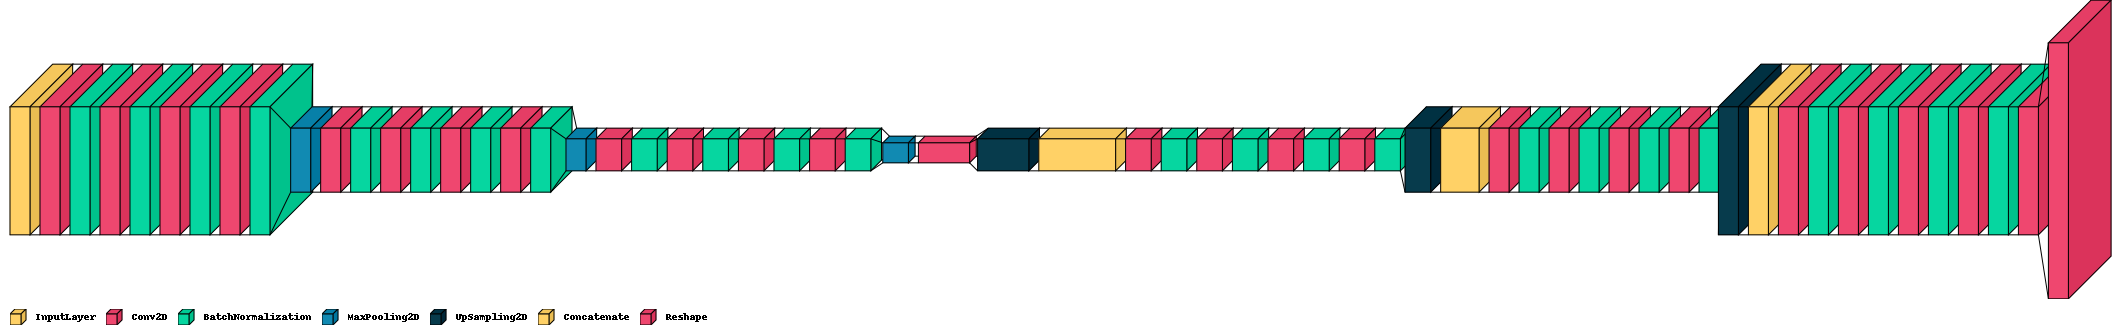

In [ ]:
#VISUALIZE THE NETWORK:

!pip3 install visualkeras
import visualkeras
from PIL import ImageFont

font = ImageFont.load_default()

visualkeras.layered_view(unet, legend=True, font= font) 

# **3. Training Phase**

At this point, the model has to be trained so that it can perform the separation of the two input signals (images) from the given data samples.

## **3.1 Create the dataset**

First of all, the `datagenerator()` function is used to generate randomly different batches of sample data. In particular, given `batch_size = 64` we have that `datagenerator()` iteratively generates batches of 64 random samples and their correspondent labels. This procedure, which allows to create an arbitrary number of batches that are different at each epoch, prevents the occurrance overfitting.

In [ ]:
#CREATE TRAIN, VALIDATION AND TEST SAMPLES:

batch_size = 64

#train set generator: 
train_generator = datagenerator(mnist_x_train,fashion_mnist_x_train, batch_size)

#validation set generator: 
validation_generator = datagenerator(mnist_x_test,fashion_mnist_x_test, batch_size)

#test set generator:
test_generator = datagenerator(mnist_x_test,fashion_mnist_x_test, batch_size)

## **3.2 Define training parameters**

The model is compiled, defining *Binary Cross-Entropy* as loss function, *Mean Squared Error* as metrics to evaluate the model and *Adam* as optimizer. 

In [ ]:
#TRAINING AND TESTING PARAMETERS

epochs_num = 200
steps_per_epoch = 937       #total train samples 60'000
validation_steps = 187      #total validation samples 12'000
test_steps = 312            #total test samples 20'000

In [ ]:
from tensorflow.keras.optimizers import Adam

unet.compile(optimizer= 'adam', loss = 'binary_crossentropy', metrics=['mse'])

The following callbacks are used:

- *checkpoint callback* saves checkpoints of the weights values while the model is training;

- *reduce learning rate on plateau callback* reduces the learning rate if the metric is not improving.

In [ ]:
#CALLBACKS

from  tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau

#model checkpoint: 
model_checkpoint_callback = ModelCheckpoint(filepath="/content", save_weights_only=True, monitor='mse', mode='min')

#reduce learning rate plateau:
reduce_lr_callback = ReduceLROnPlateau(monitor="mse", mode = 'min', patience=5, min_lr=0.0001)


## **3.3 Fit the model**

The network is trained on `steps_per_epoch = 937` number of batches of 64 randomly generated samples, which define a training set of approximately 60'000 samples per epoch. 

In [ ]:
#TRAIN THE MODEL

#training:
history = unet.fit(train_generator, epochs=epochs_num, batch_size = batch_size, 
                   steps_per_epoch = steps_per_epoch, validation_steps = validation_steps,  
                   validation_data = validation_generator, shuffle = True, 
                   callbacks = [reduce_lr_callback, model_checkpoint_callback])  

#save_weights:
unet.save_weights('unet_weights.h5')

Epoch 1/200
937/937 [==============================] - 95s 94ms/step - loss: 0.1835 - mse: 0.0170 - val_loss: 0.1352 - val_mse: 0.0057 - lr: 0.0010
Epoch 2/200
937/937 [==============================] - 87s 92ms/step - loss: 0.1306 - mse: 0.0048 - val_loss: 0.1276 - val_mse: 0.0037 - lr: 0.0010
Epoch 3/200
937/937 [==============================] - 86s 92ms/step - loss: 0.1265 - mse: 0.0036 - val_loss: 0.1298 - val_mse: 0.0046 - lr: 0.0010
Epoch 4/200
937/937 [==============================] - 86s 92ms/step - loss: 0.1249 - mse: 0.0030 - val_loss: 0.1257 - val_mse: 0.0030 - lr: 0.0010
Epoch 5/200
937/937 [==============================] - 86s 92ms/step - loss: 0.1233 - mse: 0.0026 - val_loss: 0.1241 - val_mse: 0.0024 - lr: 0.0010
Epoch 6/200
937/937 [==============================] - 86s 92ms/step - loss: 0.1226 - mse: 0.0023 - val_loss: 0.1242 - val_mse: 0.0025 - lr: 0.0010
Epoch 7/200
937/937 [==============================] - 86s 92ms/step - loss: 0.1220 - mse: 0.0021 - val_loss: 0.

## **3.4 Visualize the results of the training phase**

Once the model has been fitted, the `history` values can be used to plot the results to see the trend of the loss function and of the *Mean Squared Error* throughout the entire training phase.



UNet training results:


 Results on UNet:



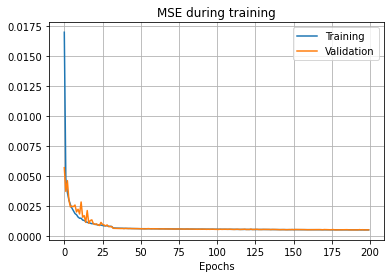

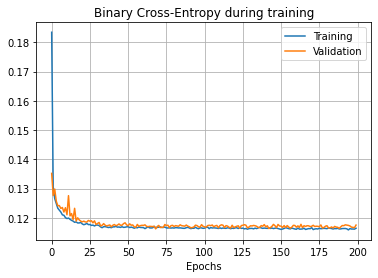

In [ ]:
#PLOT MEAN SQUARED ERROR ACCURACY
def display_history(history, model_name):
    mse_training = history.history['mse']
    loss_training = history.history['loss']

    mse_val = history.history['val_mse']
    loss_val = history.history['val_loss']

    print(f'\n\n Results on {model_name}:\n')

    # Visualize the behavior of the loss
    plt.plot(mse_training)
    plt.plot(mse_val)
    plt.grid()
    plt.title('MSE during training')
    plt.xlabel('Epochs')
    plt.legend(['Training', 'Validation'])
    plt.show()

    # and of the accuracy
    plt.plot(loss_training)
    plt.plot(loss_val)
    plt.grid()
    plt.title('Binary Cross-Entropy during training')
    plt.xlabel('Epochs')
    plt.legend(['Training', 'Validation'])
    plt.show()

#displaying results:
print('\n\nUNet training results:')

#loss and mse
display_history(history, 'UNet')

As we can see from the previous plots, the overall error given by the *Mean Squared Error* on both train and validation sets decreases following the same trend, meaning that the model is not subject to overfitting. 

# **4. Evaluate the model on test data**

Once the model has been trained, it can be evaluated on the test set by using the `evaluate()` function. As already pointed out, `test_generator` creates different data every time, so it is a good practice to evaluate the model multiple times, compute for each different test set the *Mean Squared Error* and finally compute their standard deviation.   

In [ ]:
#EVALUATE MODEL ON TEST SET
mse_for_stdv = []

for i in range(10):
  test_history = unet.evaluate(test_generator, steps = test_steps, batch_size = batch_size, verbose = 2)
  mse_for_stdv.append(test_history[1])

mse_stdev = np.std(mse_for_stdv, dtype=np.float64)

print("Computed Mean Squared Errors:")
for i in range(10):
  print(mse_for_stdv[i])

print(f"\nStandard deviation of computed Mean Squared Errors:  {mse_stdev}")

312/312 - 8s - loss: 0.1165 - mse: 5.2405e-04 - 8s/epoch - 26ms/step
312/312 - 8s - loss: 0.1166 - mse: 5.1968e-04 - 8s/epoch - 27ms/step
312/312 - 8s - loss: 0.1170 - mse: 5.1816e-04 - 8s/epoch - 25ms/step
312/312 - 8s - loss: 0.1172 - mse: 5.2295e-04 - 8s/epoch - 26ms/step
312/312 - 8s - loss: 0.1170 - mse: 5.1775e-04 - 8s/epoch - 25ms/step
312/312 - 8s - loss: 0.1172 - mse: 5.1528e-04 - 8s/epoch - 25ms/step
312/312 - 8s - loss: 0.1170 - mse: 5.1395e-04 - 8s/epoch - 26ms/step
312/312 - 8s - loss: 0.1169 - mse: 5.1650e-04 - 8s/epoch - 25ms/step
312/312 - 8s - loss: 0.1171 - mse: 5.1757e-04 - 8s/epoch - 25ms/step
312/312 - 8s - loss: 0.1170 - mse: 5.1978e-04 - 8s/epoch - 25ms/step
Computed Mean Squared Errors:
0.0005240526515990496
0.0005196843412704766
0.0005181576125323772
0.0005229496746324003
0.0005177503335289657
0.0005152762169018388
0.0005139469867572188
0.000516498985234648
0.0005175711703486741
0.0005197763675823808

Standard deviation of computed Mean Squared Errors:  3.00479

# 5. **Conclusions**

As expected, the UNet architecture allows to perform a *Blind Signal Separation* (BSS) obtaining really good results in terms of minimizing the *Mean Squared Error* and in terms of image reconstruction. In the following, few random samples of the test set are displayed after beeing processed to obtain the two reconstructed images. 

Some random reconstructed images:


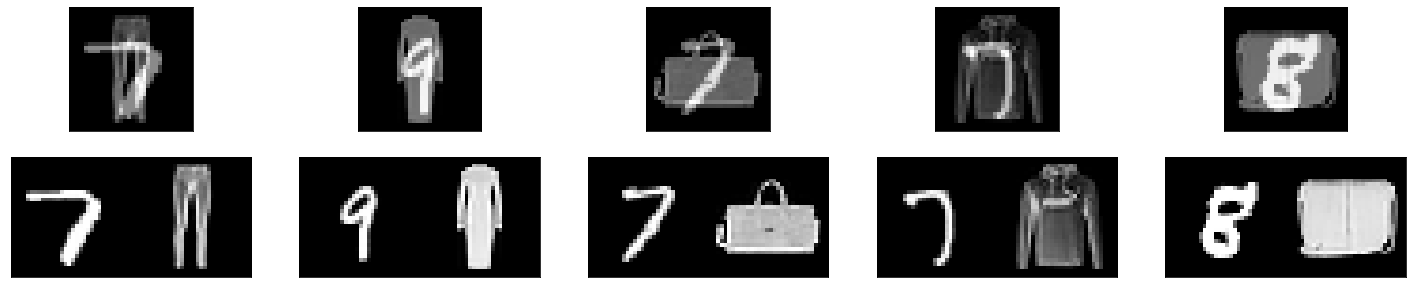

In [ ]:
#DISPLAY RECONSTRUCTED IMAGES
import random

def samples_check(predicted_images, x_test, batch_size):

  n = 5
  random_samples = []

  for i in range(n):
    random_samples.append(random.randint(0, 63))

  plt.figure(figsize=(25, 5))


  print('Some random reconstructed images:')

  for i in range(n):

      #samples
      ax = plt.subplot(2, n, i+1)
      plt.imshow(np.squeeze(x_test[random_samples[i]]), cmap='gray', interpolation='nearest')
      plt.gray()
      ax.get_xaxis().set_visible(False)
      ax.get_yaxis().set_visible(False)

      # display reconstruction
      ax = plt.subplot(2, n, i+1 + n)
      plt.imshow(np.squeeze(predicted_images[random_samples[i]]), cmap='gray', interpolation='nearest')
      plt.gray()
      ax.get_xaxis().set_visible(False)
      ax.get_yaxis().set_visible(False)
      
  plt.show()

x_test, y_test = next(test_generator)
predicted_images = unet.predict(x_test, batch_size = batch_size)

samples_check(predicted_images, x_test, batch_size)